# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from sklearn.model_selection import train_test_split
import copy
import cv2

In [2]:
from stm_utils import Sxm_Image
from CITS_Class import CITS_Analysis
from torch.utils.data import DataLoader, Dataset

In [3]:
from im2spec_models import *
from im2spec_dataset import *
from training_functions import *
from plot_functions import *
from BEPS_functions import *

In [4]:
import atomai as aoi
from atomai.utils import get_coord_grid, extract_patches_and_spectra, extract_patches, extract_subimages

# Get data

Value Range: 0.0 1.0 0.0 1.0


Text(0, 0.5, 'Piezoresponse (a.u.)')

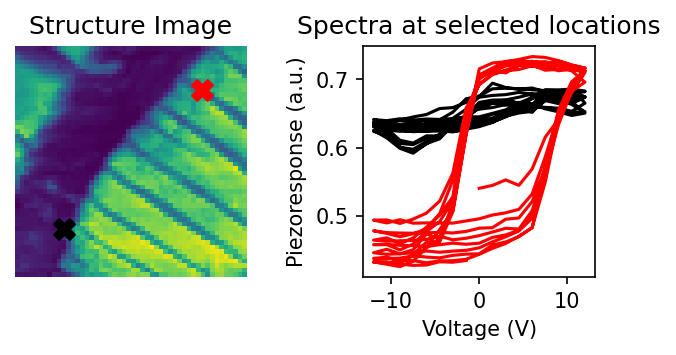

In [5]:
beps_file = r"BEPS_data/PTO_BEPS_1um.npz"

full_image, spectra, v_step = extract_beps_data(beps_file)
print("Value Range:", full_image.min(), full_image.max(), spectra.min(), spectra.max())

spec_pixel_x1 = 10; spec_pixel_y1 = 10
spec_pixel_x2 = 40; spec_pixel_y2 = 40
# Plot image and spectra at selected locations
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2), dpi = 150)
plt.subplots_adjust(wspace=0.5)

ax1.imshow(full_image, origin = "lower")
ax1.scatter(spec_pixel_x1, spec_pixel_y1, marker='X', s=100, c='k')
ax1.scatter(spec_pixel_x2, spec_pixel_y2, marker='X', s=100, c='r')
ax1.set_title('Structure Image')
ax1.axis("off")

ax2.set_title("Spectra at selected locations")  # Note: Convention of the spectra indices is reversed!!!
ax2.plot(v_step, spectra[spec_pixel_y1, spec_pixel_x1], c = 'k')
ax2.plot(v_step, spectra[spec_pixel_y2, spec_pixel_x2], c = 'r')
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Piezoresponse (a.u.)')


## Get image-patches and spectral pairs

(1225, 16, 16) (1225, 256) (256,)


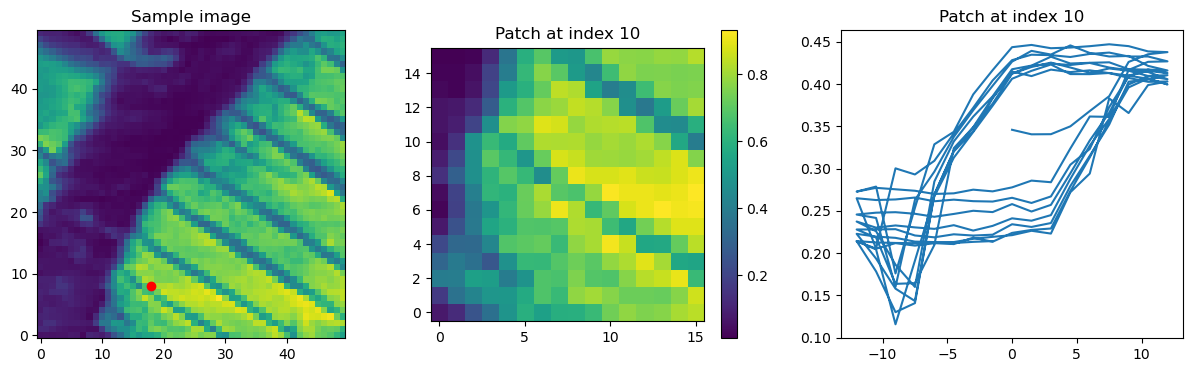

In [6]:
images, spectra, coordinates, vstep = BEPS_image_spectral_pairs(beps_file)

print(images.shape, spectra.shape, vstep.shape)


fig, ax = plt.subplots(1, 3, figsize = (15, 4))


idx = 10

ax[0].imshow(full_image, origin = 'lower')
ax[0].scatter(coordinates[idx, 1], coordinates[idx, 0], c ="r")
ax[0].set_title("Sample image")


im = ax[1].imshow(images[idx], origin = 'lower')
fig.colorbar(im, ax=ax[1])
ax[1].set_title(f"Patch at index {idx}")
ax[2].plot(vstep, spectra[idx])
ax[2].set_title(f"Patch at index {idx}")

plt.show()

# Active learning

Train-test-split

In [15]:
test_size = 0.8


in_dim = images[0].shape  # Input dimensions (image height and width)
out_dim = len(spectra[0])  # Output dimensions (spectra length)

indices = np.arange(len(images))
imgs_train,imgs_test, spectra_train, spectra_test, indices_train, indices_test = train_test_split(images, spectra, indices, 
                                                                                                  test_size = test_size, random_state = 24)

print(imgs_train.shape, spectra_train.shape, imgs_test.shape, spectra_test.shape)
initial_trainsize = imgs_train.shape[0]

(245, 16, 16) (245, 256) (980, 16, 16) (980, 256)


Set hyperparameters

In [8]:
beta = 0.5              # set in range: [0,1]. lower beta for exploitation
n_epochs = 200                # n_epochs for im2spec training
n_epochs_error = 100         # epochs for the error model
patience = 10              # patience for earlystopping
n_batches = 16             # number of minibatches for im2spec training
sample_next_points = 10   # number of points in each iteration
p_ensemble = 0.2         # Probability of ensemble training
lambda_ = 0.1

# Define model ensemble
model_list = [im2spec, im2spec_2, im2spec_3, im2spec_4, im2spec_5]


Exploration Step:  1
Training data size:  735


Best model index: 4
latent dim: 3
(245,)


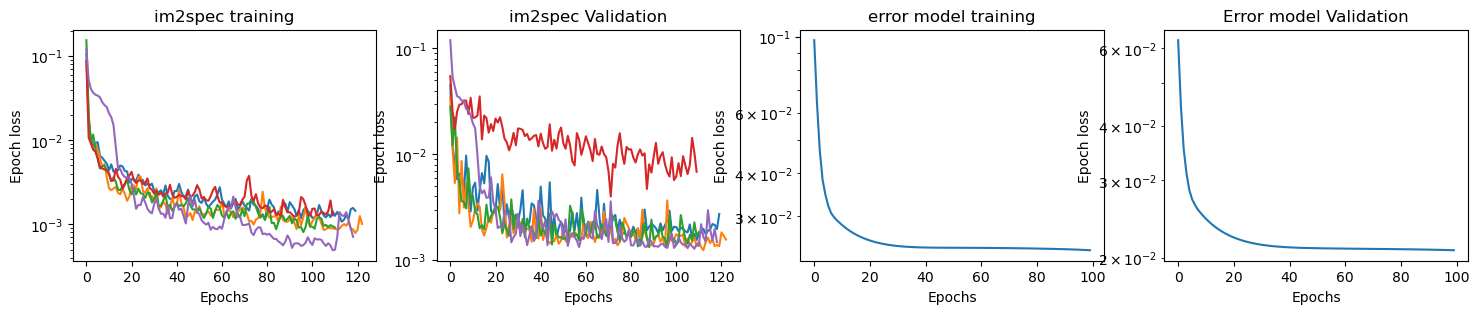

Error range: 0.19031426 0.15720378


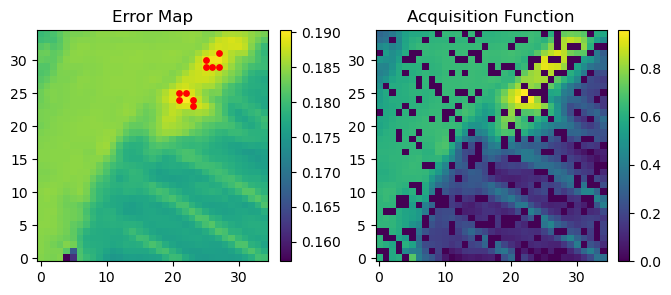

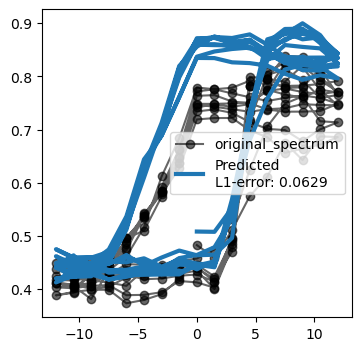

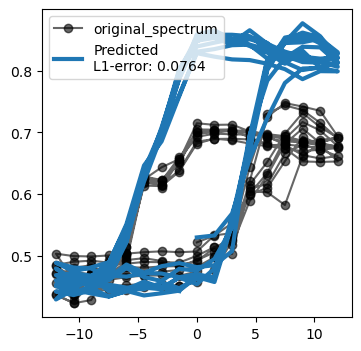

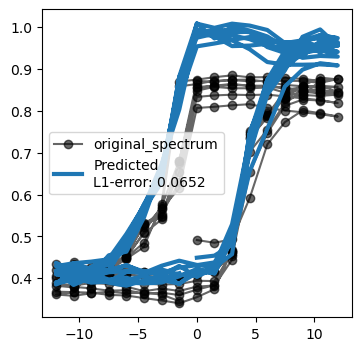

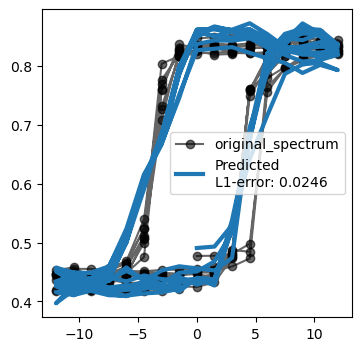

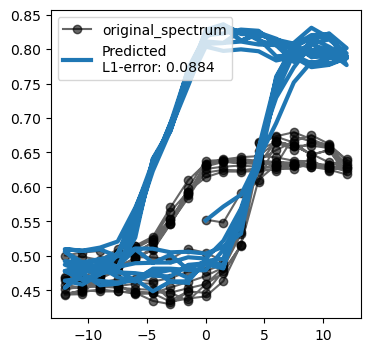

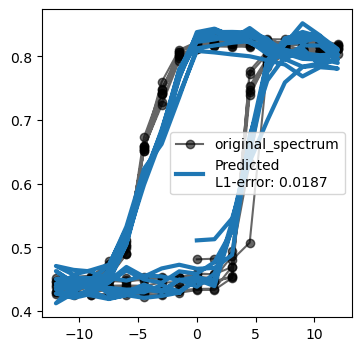

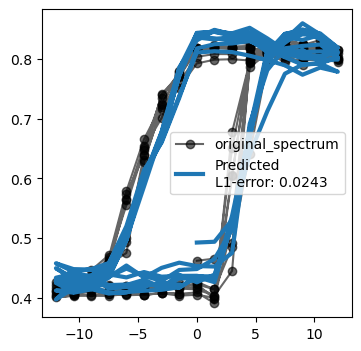

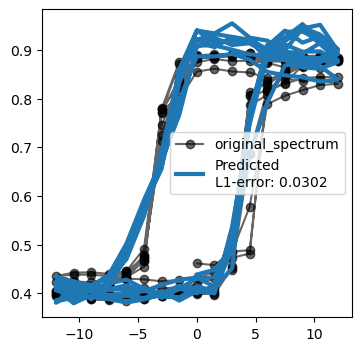

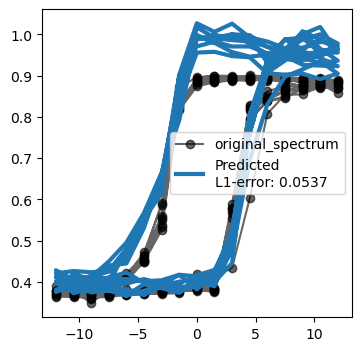

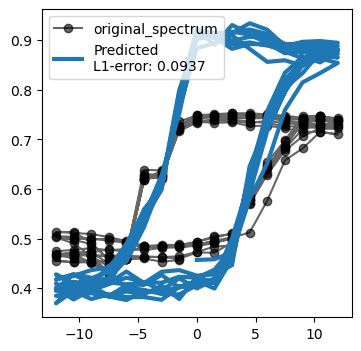

(255, 16, 16) (255, 256) (255,)


In [9]:
exploration_steps = 1

error_log = []
random_error_log = []
trainset_error = []

for i in range(exploration_steps):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Exploration Step: ', i+1)

    
#◘  Define the ensemble im2spec model. carry out ensemble training with probabiity p_ensemble
    epsilon =  np.random.rand()
    if epsilon < p_ensemble or i==0:
        model = ensemble_im2spec(in_dim, out_dim, models = model_list, force_latent_dim = 3)
        ensemble_training = True
    else:
        model = ensemble_im2spec(in_dim, out_dim, models = [model_list[best_model_idx]], force_latent_dim = latent_dim)
        ensemble_training = False

#◘   Create training dataset
    #train_dataset = im2spec_Dataset(imgs_train, spectra_train)
    
    #Create_augmented_dataset - dataset x 3
    train_dataset = augmented_dataset(imgs_train, spectra_train)
    print("Training data size: ",len(train_dataset))
    
#◘   Train the im2spec ensemble model
    model, im2spec_train_loss, im2spec_val_loss = train_model_ensemble(model, train_dataset, lr = [0.001, 0.001, 0.001, 0.001, 0.001], 
                                                                       n_epochs = n_epochs, patience = patience, 
                                                                       n_batches = n_batches, l1_rglr = False)

#◘   Choose best im2spec model - based on least val_loss
    if ensemble_training:
        best_model_idx = sort_model_idx(im2spec_val_loss, last_epochs = 50)[0]
        print("Best model index:",best_model_idx)    
        imspec_model = model.models[best_model_idx]
        
        sample_img, _ = train_dataset[0]
        
        # add batch and channel size
        emdedding = imspec_model.encoder(sample_img.unsqueeze(0).unsqueeze(1).to(device))
        latent_dim = emdedding.shape[1]   
        print("latent dim:", latent_dim)
        
    else:
        imspec_model = model.models[0]
    
#◘   Compute L1-error using spectral predictin on the train set
    spectral_error, _, _ = err_estimation(imspec_model, imgs_train, spectra_train)
    trainset_error_mean = spectral_error.mean()
    error_vector = norm_0to1(spectral_error)
     
    print(error_vector.shape)

    # Create the error training dataset
    error_training_dataset = Error_Dataset(imgs_train, error_vector)
    
#◘   Define the error model - combines trained encoder with custoom decoder
    error_model = CustomDecoder(imspec_model.encoder, latent_dim)
    error_model.to(device)
    
#◘   Train the ensemble error model
    error_model, error_train_loss, error_val_loss = train_model(error_model, error_training_dataset,
                                                                            n_batches = 1, patience = patience, lr = 0.001, n_epochs = n_epochs_error, partial_train = True)
    #print(error_train_loss[-1])
    plot_training_loss(im2spec_train_loss, im2spec_val_loss, error_train_loss, error_val_loss)
  
        
#◘   Posterior error prediction
    errors = predict_spectra(error_model, images, ensemble = False)
    #print(errors.shape)
    print("Error range:", errors.max(), errors.min())
    

#◘   Acquire the next (set of) index using the acquisiton function
    aq_ind, aq_fn = distance_acq_fn(errors, beta = beta, lambda_ = lambda_, sample_next_points = sample_next_points, exclude_indices = indices_train)

    plot_error_prediction(errors, aq_fn, coordinates, aq_ind)
    
#◘   Plot next acquisitions 
    
    for ind in aq_ind:
    
        # Acquisition point
        next_coordinate = coordinates[ind]
        predicted_spectra = predict_spectra(imspec_model, images[ind:ind+1], ensemble = False)
                
        spectral_error, _, _ = err_estimation(imspec_model, images[ind:ind+1], spectra[ind:ind+1])
        error_log.append(spectral_error.mean())
        plot_spectra([predicted_spectra], spectra[ind], spectral_error.mean(), xdata = vstep)
        
        #Randomly sampled point
        rand_ind = random.choice(indices_test)
        rand_spectral_error, _, _ = err_estimation(imspec_model, images[rand_ind:rand_ind+1], spectra[rand_ind:rand_ind+1])
        random_error_log.append(rand_spectral_error.mean())
        
        # Update train and test sets
        imgs_train, spectra_train, indices_train = append_training_set(images, spectra, ind, imgs_train, spectra_train, indices_train)
        indices_test = np.delete(indices_test, np.where(indices_test == ind))
        
        trainset_error.append(trainset_error_mean)
        
    print(imgs_train.shape, spectra_train.shape, indices_train.shape)

    
    
error_log = np.asarray(error_log)
random_error_log = np.asarray(random_error_log)

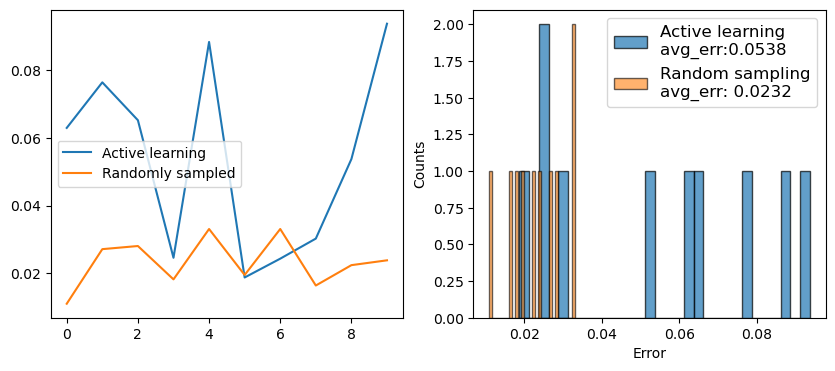

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

ax[0].plot(error_log, label = f'Active learning')
ax[0].plot(random_error_log, label = f'Randomly sampled')
ax[0].legend()

ax[1].hist(error_log, bins=30, alpha=0.7, label=f'Active learning\navg_err:{error_log.mean():.4f}', color='#1f77b4', edgecolor='black')
ax[1].hist(random_error_log, bins=30, alpha=0.6, label=f'Random sampling\navg_err: {random_error_log.mean():.4f}', color='#ff7f0e', edgecolor='black')
ax[1].set_xlabel('Error')
ax[1].set_ylabel('Counts')
ax[1].legend(fontsize = 'large')

plt.show()

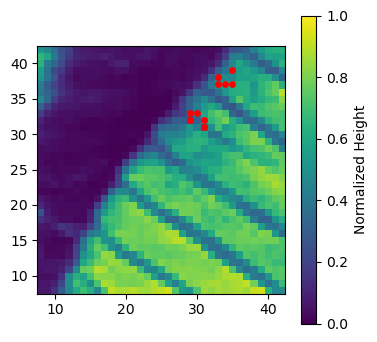

In [11]:
# PLot exploration points on the topography data

plt.figure(figsize = [4, 4])
a =plt.imshow(full_image, origin = 'lower')

for ind in indices_train[initial_trainsize:]:
    plt.scatter(coordinates[ind, 1], coordinates[ind, 0], c = 'r', s = 15) 

plt.colorbar(a, label = 'Normalized Height')
plt.ylim(7.5, 42.5)
plt.xlim(7.5, 42.5)
plt.show()



# Latent-space analysis

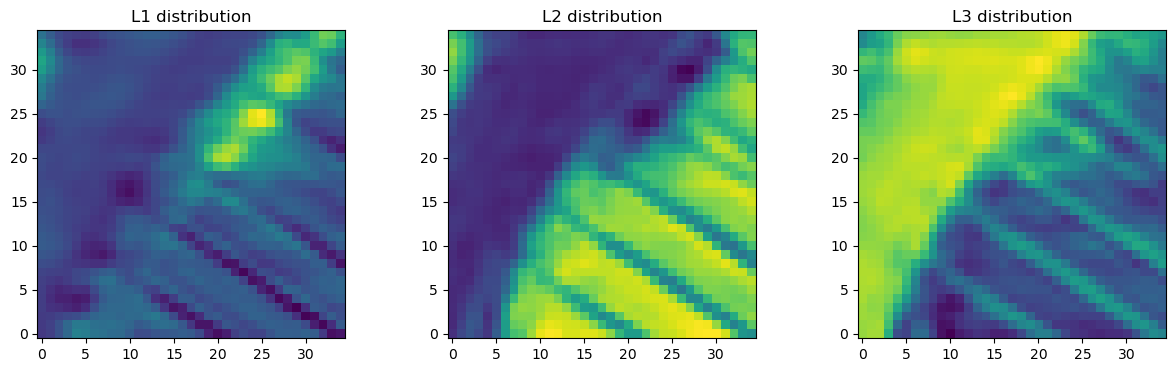

In [12]:
output_type = 'latent'
posterior_spectra = predict_posterior(imspec_model, images, output_type = output_type)    
posterior_trainset = predict_posterior(imspec_model, imgs_train, output_type = output_type)

plot_latent_distribution(posterior_spectra)


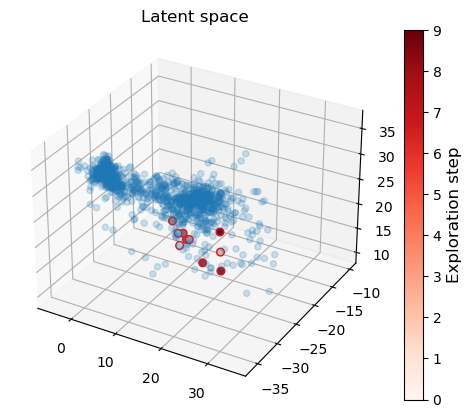

In [13]:
posterior_trainset = predict_posterior(imspec_model, imgs_train, output_type = output_type)
plot_latent_space(posterior_spectra, posterior_trainset[initial_trainsize:],lat_order = [0, 1, 2])

(1225,)


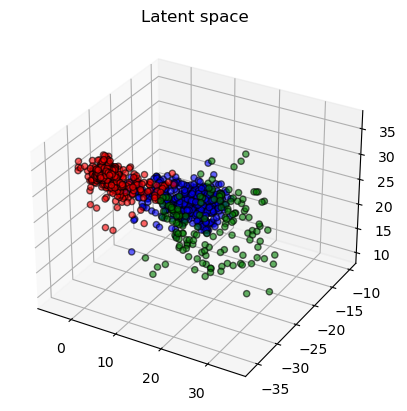

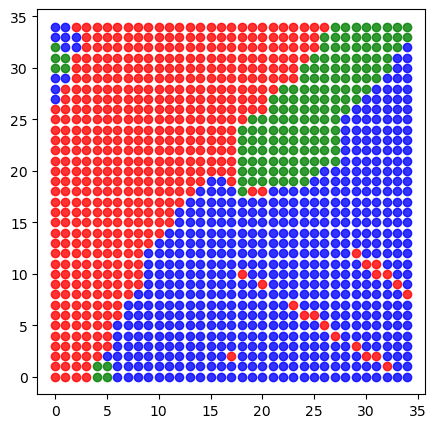

In [14]:
cluster_latent_space(posterior_spectra, lat_order = [0, 1, 2],  n_clusters = 3) # keep n_clusters < 5